In [1]:
import torch
from torch import nn
from torch.utils import data

from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt


from src.models import VAE

from collections import OrderedDict

from torchvision.utils import make_grid

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

net = VAE(
    dropout=False,
    inp_size=28 * 28,
    emb_size=(28 * 28) // 2,
    lat_size=2,
).to(device)

In [26]:
state_dict = torch.load(
    f="./mnist_test_logs/lightning_logs/version_18/checkpoints/epoch=9-step=3000.ckpt",
    map_location=device,
)["state_dict"]

corrupted_state_dict = state_dict  # type: OrderedDict

new_state_dict = OrderedDict()
for key, value in corrupted_state_dict.items():
    new_state_dict[key[6:]] = value

new_state_dict.pop("n.log_scale")
net.load_state_dict(new_state_dict)

<All keys matched successfully>

In [27]:
fit = MNIST("mnist/", train=True, download=True)
val = MNIST("mnist/", train=False, download=True)

num_samples = 500
x, y = fit.data[:num_samples, ...].to(torch.float64), fit.targets[:num_samples]
# x /= x.max()
x = x.flatten(1).to(device)
x = x.to(torch.float64)

In [28]:
xhat, mu, logvar = net(x)
z = net.reparameterization_mod(mu, logvar)
z.size(), y.size()

(torch.Size([500, 2]), torch.Size([500]))

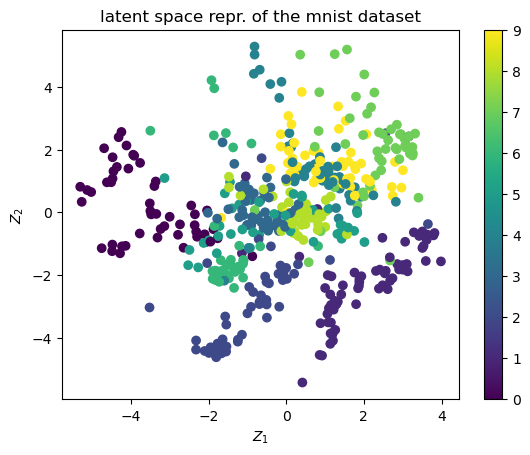

In [29]:
zz = z.detach().cpu().numpy()
yy = y.cpu().numpy()

plt.title("latent space repr. of mnist dataset")
p = plt.scatter(zz[:, 0], zz[:, 1], c=yy)
plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
# p.set_cmap("coolwarm")
cbar = plt.colorbar(p)
plt.show()

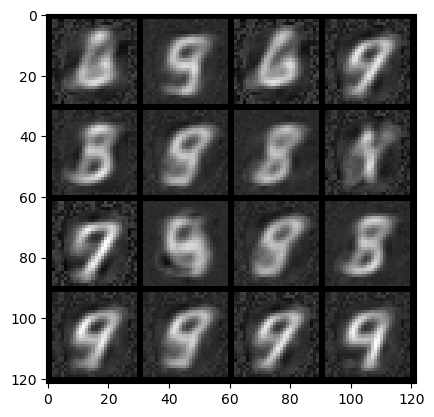

In [30]:
n_gen_samples = 4
z = torch.distributions.Normal(
    torch.zeros(size=(n_gen_samples, 2)),
    torch.ones(size=(n_gen_samples, 2)),
).rsample((n_gen_samples,))

with torch.no_grad():
    x_recons = net.decoder(z.to(torch.float64)).view(-1, 1, 28, 28)


img = make_grid(x_recons, nrow=n_gen_samples, normalize=True).permute(1, 2, 0).numpy()
plt.imshow(img)